# Expérimentation de la filtration de Morse sur des images

Dans ce notebook, on s'interresse à classifier des images de 0 et de 8 tracés à la main selon $H_1$.

## Importer les données de MNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

On importe les données de chiffres écrits à la main de MNIST. On garde seulement les 0 et les 8. 

In [2]:
digits = datasets.load_digits()
indices = (digits.target == 0) | (digits.target == 8)
y = digits.target[indices]

X = digits.data[indices].reshape([sum(indices), 8, 8])


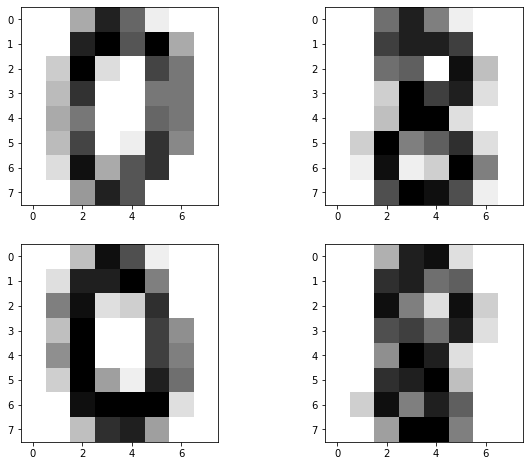

In [3]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(X[0], cmap='gray_r')
plt.subplot(2,2,2)
_=plt.imshow(X[1], cmap='gray_r')
plt.subplot(2,2,3)
plt.imshow(X[40], cmap='gray_r')
plt.subplot(2,2,4)
_=plt.imshow(X[51], cmap='gray_r')

## Preparation des données

Afin de différentier les deux troues du 8, on multiplie chaque pixel (x,y) par $1 + \frac{1}{2} y$. Par la suite, on normalise la valeur des pixels de chaque image entre 0 et 1.

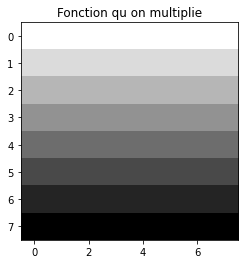

In [4]:
dists = 1 + 0.5 * np.array([[ y for x in range(8) ] for y in range(8)])
plt.imshow(dists, cmap='gray_r')
_=plt.title('Fonction qu on multiplie')
X_1 = X * dists[np.newaxis,:,:]
X_1 = -X_1 /np.max(X_1)+1

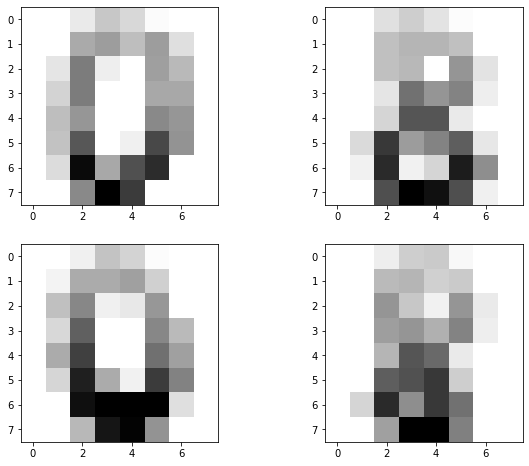

In [5]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.imshow(X_1[0], cmap='gray')
plt.subplot(2,2,2)
_=plt.imshow(X_1[1], cmap='gray')
plt.subplot(2,2,3)
plt.imshow(X_1[40], cmap='gray')
plt.subplot(2,2,4)
_=plt.imshow(X_1[51], cmap='gray')

## Calcul des diagrammes de persistances avec les filtrations de Morse

In [6]:
from Complexe import Complexe
from Gestion_Image import Calcul_Valeur_Sommet, Import_Image_Fixe_Dim
import gudhi as gd
import gudhi.representations
from gudhi.persistence_graphical_tools import plot_persistence_diagram
from gtda.homology import CubicalPersistence

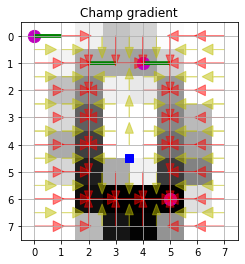

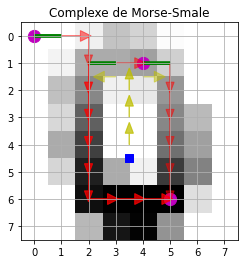

In [7]:
# Exemple de calcul d'un champs gradient et de son complexe de Morse résultant. 

ind = 40
Valeur_0 = Calcul_Valeur_Sommet(X_1[ind])

comp = Complexe()
comp.Init_Rectangle(8,8)
CG = comp.Calcul_Champs_Gradient(Valeur_0)
CG.Affichage(X_1[ind])

MS = CG.Calcul_Complexe_De_Morse()
MS.Affichage(X_1[ind])
dgm = MS.Filtration()

On calcul les pairs critiques pour l'ensemble du jeu de données. Puis, on sélectionne seulement les pairs de simplifications 1-2 cal elle sont liées à $H_1$.  C'est-à-dire au nombre de trous dans l'image. Finalement, on fait la conversion du format en numpy.matrix. Pour ce faire, on doit compléter et dupliquant certain point des diagrammes de persistance.

In [8]:
# Calcul des pairs critiques 

List_persistence = []

for i in range(len(X_1)):
    Valeur_0 = Calcul_Valeur_Sommet(X_1[i])
    comp = Complexe()
    comp.Init_Rectangle(8,8)
    CG = comp.Calcul_Champs_Gradient(Valeur_0)
    #CG.Epsilon_Simplification()
    MS = CG.Calcul_Complexe_De_Morse()
    dgm = MS.Filtration()
    LIsttt = dgm.Get_Liste()
    List_persistence.append(LIsttt)

    
# Sélection des 1-2 simplifications seulement

dim = 1
List_persistence2 = []

for i in range(len(X_1)):
    List_persistence2.append([])
    for j in range(len(List_persistence[i])):
        if List_persistence[i][j][2] == dim :
            List_persistence2[i].append(List_persistence[i][j])
            
            
# Conversion du format en numpy.matrix. Pour ce faire, on doit compléter et duplicant certain point  

long =[]

for i in range(len(X_1)):
    long.append(len(List_persistence2[i]))
    
max_long = max(long)

for i in range(len(X_1)):
    nb_pair = len(List_persistence2[i])
    if nb_pair == 0 :
        List_persistence2[i] = np.array([[0,0,dim] for j in range(max_long-nb_pair)])
    else:
        temp = np.array([List_persistence2[i][nb_pair-1] for j in range(max_long-nb_pair)])
        if nb_pair != max_long :
            List_persistence2[i] = np.append(List_persistence2[i],temp,axis=0)
            
persistence_Morse = np.array(List_persistence2)

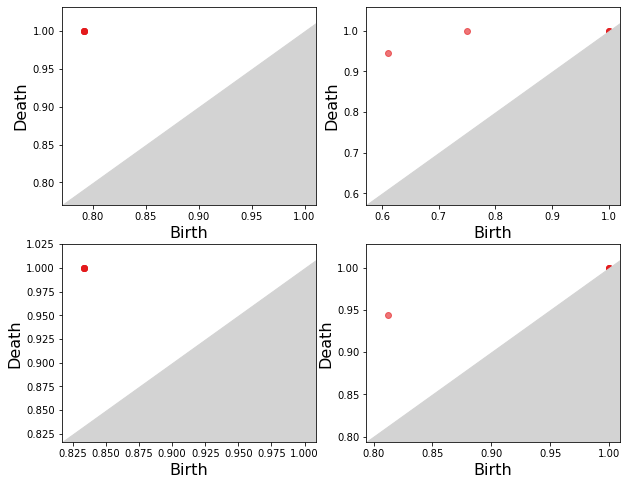

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
plot_persistence_diagram(persistence_Morse[0][:,[0,1]], axes=axs[0][0])
plot_persistence_diagram(persistence_Morse[1][:,[0,1]], axes=axs[0][1])
plot_persistence_diagram(persistence_Morse[40][:,[0,1]], axes=axs[1][0])
plot_persistence_diagram(persistence_Morse[51][:,[0,1]], axes=axs[1][1])
_=[[a.set_title("") for a in ax] for ax in axs]

## Calcul des diagrammes de persistance avec l'homologie cubique

In [10]:
cp = CubicalPersistence(homology_dimensions=[1], coeff=2, periodic_dimensions=None)
persistence_Cubique = cp.fit_transform(X_1)

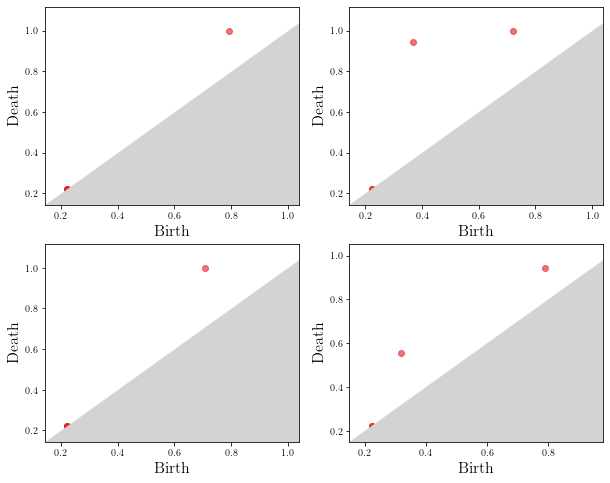

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
plot_persistence_diagram(persistence_Cubique[0][:,[0,1]], axes=axs[0][0])
plot_persistence_diagram(persistence_Cubique[1][:,[0,1]], axes=axs[0][1])
plot_persistence_diagram(persistence_Cubique[40][:,[0,1]], axes=axs[1][0])
plot_persistence_diagram(persistence_Cubique[51][:,[0,1]], axes=axs[1][1])
_=[[a.set_title("") for a in ax] for ax in axs]

## Vectorsation des diagrammes de persistance

In [12]:
from gtda.diagrams import PersistenceImage
from teaspoon.ML import feature_functions as fF
from teaspoon.ML import Base
import pandas as pd

### Images de persistance

Images de persistance avec une résolution de 15 x 15 et un noyau gaussien de variance 0.05.

In [13]:
pi_res = 15
sigma = 0.05
pi = PersistenceImage(sigma=sigma, n_bins=pi_res, weight_function=None)
persistence_images_Morse = pi.fit_transform(persistence_Morse)[:,0]
persistence_images_Cubique = pi.fit_transform(persistence_Cubique)[:,0]

En prenant la moyenne des images de persistance pour chaque classe issues de la filtration de Morse, on obtient les images suivantes.

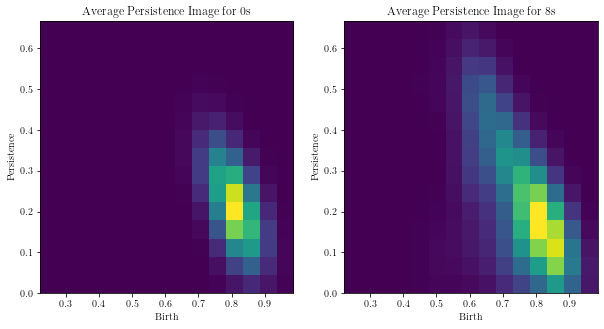

In [14]:
extent = [min(pi.samplings_[1][0]), max(pi.samplings_[1][0]), min(pi.samplings_[1][1]), max(pi.samplings_[1][1])]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.mean(persistence_images_Morse[y == 0], axis=0), aspect='auto', extent=extent)
plt.xlabel("Birth")
plt.ylabel("Persistence")
plt.title("Average Persistence Image for 0s")
plt.subplot(1,2,2)
plt.imshow(np.mean(persistence_images_Morse[y == 8], axis=0), aspect='auto', extent=extent)
plt.xlabel("Birth")
plt.ylabel("Persistence")
_=plt.title("Average Persistence Image for 8s")

### Fonctions templates

La librairie Teaspoon prend les données sous forme de pandas.Series. On change donc le format.

In [15]:
# Pour les diagrammes de persistance issues de la filtration de Morse.

index = list(range(np.shape(persistence_Morse)[0]))
DF_Morse = pd.DataFrame(columns=['Dgm1'], index=index, dtype=object)

for i in range(len(index)):
    data = {'Dgm1':persistence_Morse[i,:,[0,1]].T}
    DF_Morse.loc[i] = data

In [16]:
# Pour les diagrammes de persistance issues de la filtration cubique.

index = list(range(np.shape(persistence_Cubique)[0]))
DF_Cubique = pd.DataFrame(columns=['Dgm1'], index=index, dtype=object)

for i in range(len(index)):
    data = {'Dgm1':persistence_Cubique[i,:,[0,1]].T}
    DF_Cubique.loc[i] = data

Fonction polynomiale avec d = 20, et les polynômes de Chebichev.

In [17]:
# Pour les diagrammes de persistance issues de la filtration de Morse.
params = Base.ParameterBucket()
params.feature_function = fF.interp_polynomial
params.k_fold_cv=5
params.d = 20
params.makeAdaptivePartition(DF_Morse['Dgm1'], meshingScheme=None)
params.jacobi_poly = 'cheb1'  # choose the interpolating polynomial

feature_poly_Morse = Base.build_G(DF_Morse['Dgm1'], params)

In [18]:
# Pour les diagrammes de persistance issues de la filtration cubique.
params = Base.ParameterBucket()
params.feature_function = fF.interp_polynomial
params.k_fold_cv=5
params.d = 20
params.makeAdaptivePartition(DF_Cubique['Dgm1'], meshingScheme=None)
params.jacobi_poly = 'cheb1'  # choose the interpolating polynomial

feature_poly_Cubique = Base.build_G(DF_Cubique['Dgm1'], params)

Fonctions tentes avec d = 20, delta = 0.05 et epsion = $10^{-10}$

In [19]:
# Pour les diagrammes de persistance issues de la filtration de Morse.
params = Base.ParameterBucket()
params.feature_function = fF.tent
params.k_fold_cv=5
params.d = 20
params.delta = 0.05
params.epsilon = 1e-10

# compute features
feature_tente_Morse = Base.build_G(DF_Morse['Dgm1'], params)

# Pour les diagrammes de persistance issues de la filtration cubique.
feature_tente_Cubique = Base.build_G(DF_Cubique['Dgm1'], params)

## Un peu d'apprentisage automatique afin de classifier les 0 et les 8 

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
import seaborn as sns

Chaque jeu de donnés est séparé avec un ensemble d'entrainement et un ensemble de test. On entraine 6 modèle avec les donnée d'entrainement. Finalement, on affiche l'accuracy et la matrice de confusion pour chaque modèle.

### Images initialles

                  Modèle  Accuracy   AUC
0  Regression logistique  1.000000  1.00
1                    SVM  0.990566  0.99
2                    KNN  1.000000  1.00
3      Arbre de decision  0.971698  0.97
4        Foret aleatoire  1.000000  1.00
5            Naive Bayes  1.000000  1.00


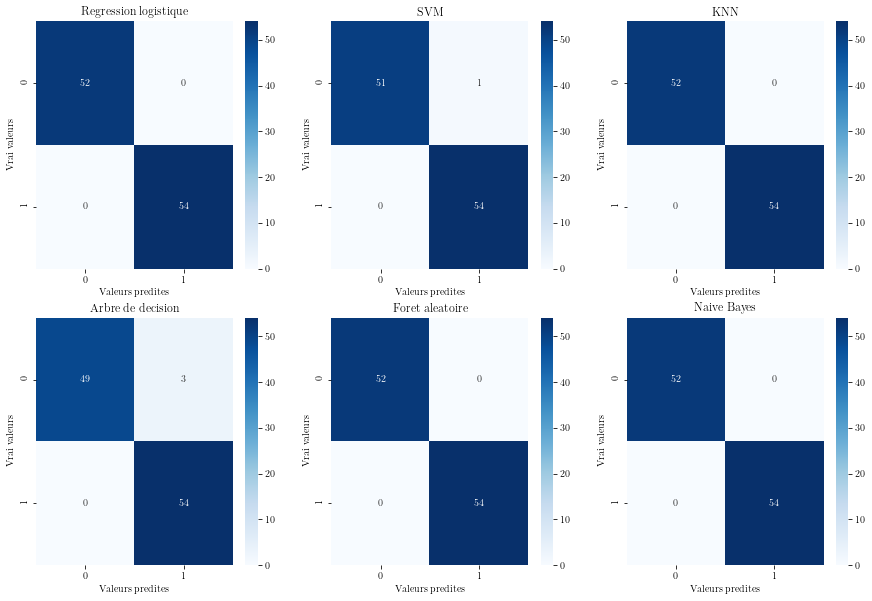

In [21]:
# Séparer les données d'entrainement et de test. 

X_train, X_test, y_train, y_test = train_test_split(
    X_1.reshape(len(y), np.shape(X_1)[1]*np.shape(X_1)[2]), y, test_size=0.3, random_state=1)


# Liste des différents modèles de classification utilisés

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())


# Entrainement 

model_list = ['Regression logistique', 'SVM', 'KNN', 'Arbre de decision', 'Foret aleatoire', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for classifier in model_pipeline:
    model = make_pipeline(StandardScaler(), classifier)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 8)
    auc_list.append(round(metrics.auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))


# Afficher l'accuracy et l'AUC.

result_df = pd.DataFrame({'Modèle':model_list,'Accuracy':acc_list,'AUC':auc_list})
print(result_df)


# Afficher les différentes matrices de confusions   

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    
    cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('Valeurs predites')
    cm_plot.set_ylabel('Vrai valeurs')

### Images de pesistance avec filtration de Morse

                  Modèle  Accuracy   AUC
0  Regression logistique  0.915094  0.91
1                    SVM  0.905660  0.90
2                    KNN  0.886792  0.89
3      Arbre de decision  0.839623  0.84
4        Foret aleatoire  0.867925  0.87
5            Naive Bayes  0.773585  0.78


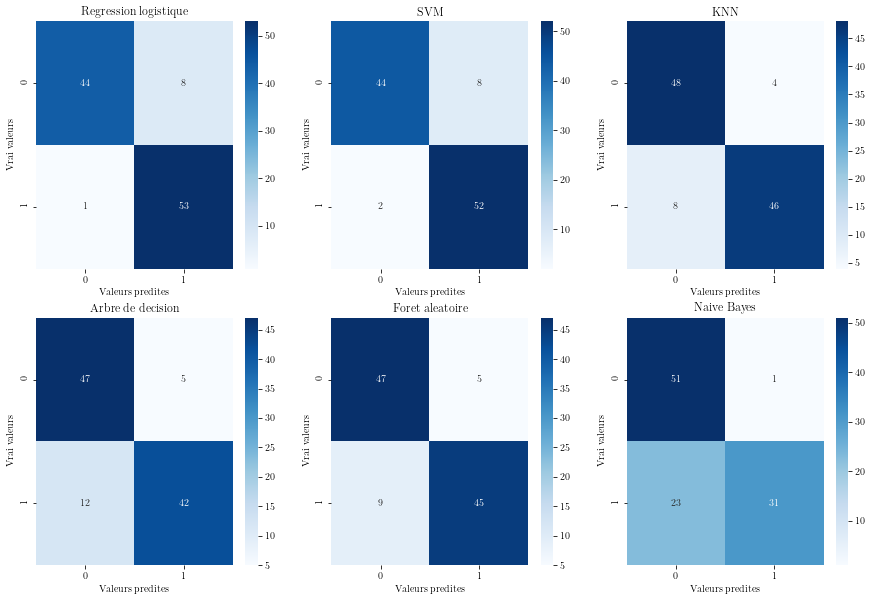

In [22]:
# Séparer les données d'entrainement et de test. 

X_train, X_test, y_train, y_test = train_test_split(
    persistence_images_Morse.reshape(len(y), pi_res**2), y, test_size=0.3, random_state=1)


# Liste des différents modèles de classification utilisés

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())


# Entrainement 

model_list = ['Regression logistique', 'SVM', 'KNN', 'Arbre de decision', 'Foret aleatoire', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for classifier in model_pipeline:
    model = make_pipeline(StandardScaler(), classifier)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 8)
    auc_list.append(round(metrics.auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))


# Afficher l'accuracy et l'AUC.

result_df = pd.DataFrame({'Modèle':model_list,'Accuracy':acc_list,'AUC':auc_list})
print(result_df)


# Afficher les différentes matrices de confusions   

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    
    cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('Valeurs predites')
    cm_plot.set_ylabel('Vrai valeurs')

### Images de pesistance avec filtration de Cubique

                  Modèle  Accuracy   AUC
0  Regression logistique  0.933962  0.93
1                    SVM  0.962264  0.96
2                    KNN  0.905660  0.91
3      Arbre de decision  0.924528  0.93
4        Foret aleatoire  0.943396  0.94
5            Naive Bayes  0.933962  0.93


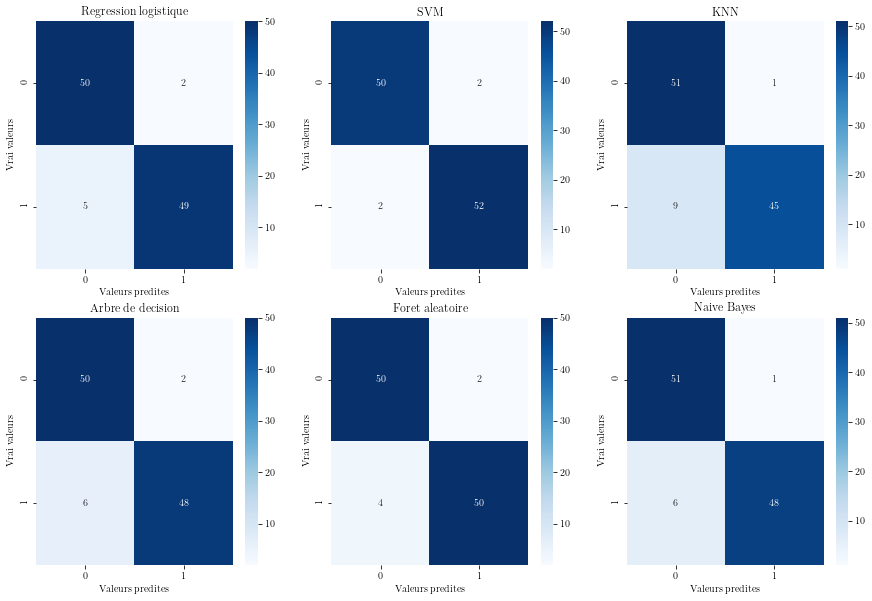

In [23]:
# Séparer les données d'entrainement et de test. 

X_train, X_test, y_train, y_test = train_test_split(
    persistence_images_Cubique.reshape(len(y), pi_res**2), y, test_size=0.3, random_state=1)


# Liste des différents modèles de classification utilisés

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())


# Entrainement 

model_list = ['Regression logistique', 'SVM', 'KNN', 'Arbre de decision', 'Foret aleatoire', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for classifier in model_pipeline:
    model = make_pipeline(StandardScaler(), classifier)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 8)
    auc_list.append(round(metrics.auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))


# Afficher l'accuracy et l'AUC.

result_df = pd.DataFrame({'Modèle':model_list,'Accuracy':acc_list,'AUC':auc_list})
print(result_df)


# Afficher les différentes matrices de confusions   

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    
    cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('Valeurs predites')
    cm_plot.set_ylabel('Vrai valeurs')

### Fonctions templates polynomiales avec filtration de Morse

                  Modèle  Accuracy   AUC
0  Regression logistique  0.896226  0.90
1                    SVM  0.924528  0.92
2                    KNN  0.830189  0.83
3      Arbre de decision  0.849057  0.85
4        Foret aleatoire  0.858491  0.86
5            Naive Bayes  0.830189  0.83


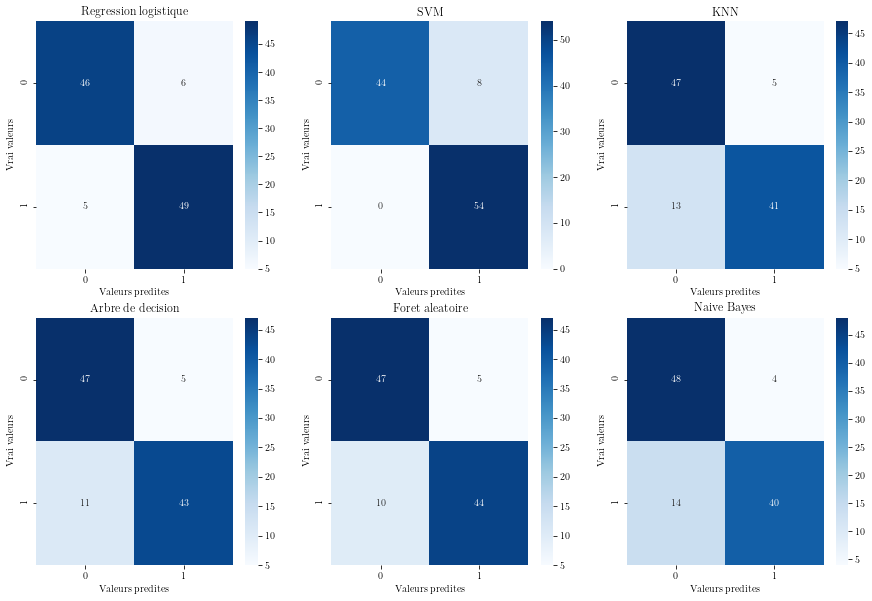

In [24]:
# Séparer les données d'entrainement et de test. 

X_train, X_test, y_train, y_test = train_test_split(feature_poly_Morse, y, test_size=0.3, random_state=1)


# Liste des différents modèles de classification utilisés

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())


# Entrainement 

model_list = ['Regression logistique', 'SVM', 'KNN', 'Arbre de decision', 'Foret aleatoire', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for classifier in model_pipeline:
    model = make_pipeline(StandardScaler(), classifier)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 8)
    auc_list.append(round(metrics.auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))


# Afficher l'accuracy et l'AUC.

result_df = pd.DataFrame({'Modèle':model_list,'Accuracy':acc_list,'AUC':auc_list})
print(result_df)


# Afficher les différentes matrices de confusions   

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    
    cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('Valeurs predites')
    cm_plot.set_ylabel('Vrai valeurs')

### Fonctions templates polynomiales avec filtration cubique

                  Modèle  Accuracy   AUC
0  Regression logistique  0.924528  0.93
1                    SVM  0.915094  0.92
2                    KNN  0.849057  0.85
3      Arbre de decision  0.867925  0.87
4        Foret aleatoire  0.849057  0.85
5            Naive Bayes  0.933962  0.93


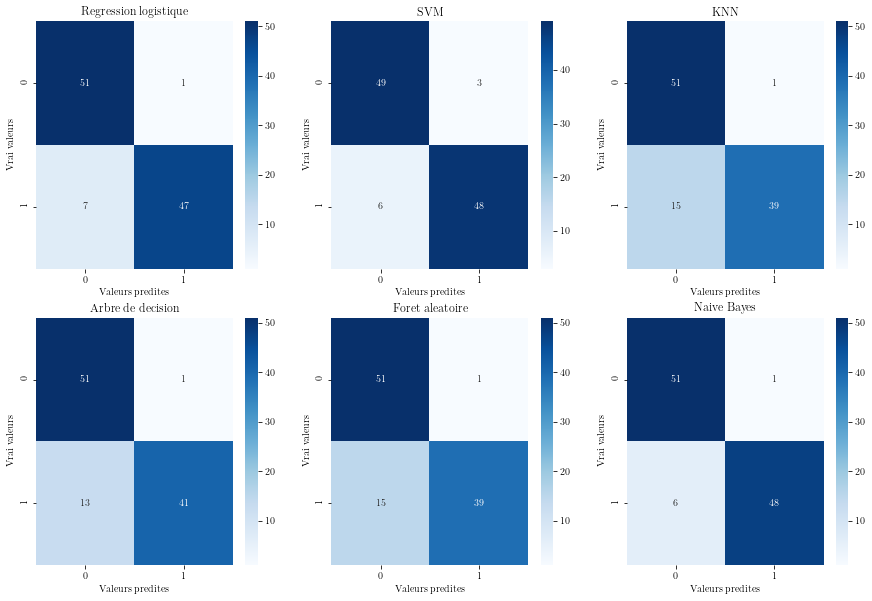

In [25]:
# Séparer les données d'entrainement et de test. 

X_train, X_test, y_train, y_test = train_test_split(feature_tente_Cubique, y, test_size=0.3, random_state=1)


# Liste des différents modèles de classification utilisés

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())


# Entrainement 

model_list = ['Regression logistique', 'SVM', 'KNN', 'Arbre de decision', 'Foret aleatoire', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for classifier in model_pipeline:
    model = make_pipeline(StandardScaler(), classifier)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 8)
    auc_list.append(round(metrics.auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))


# Afficher l'accuracy et l'AUC.

result_df = pd.DataFrame({'Modèle':model_list,'Accuracy':acc_list,'AUC':auc_list})
print(result_df)


# Afficher les différentes matrices de confusions   

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    
    cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('Valeurs predites')
    cm_plot.set_ylabel('Vrai valeurs')

### Fonctions templates tentes avec filtration de Morse

                  Modèle  Accuracy   AUC
0  Regression logistique  0.915094  0.91
1                    SVM  0.915094  0.91
2                    KNN  0.849057  0.85
3      Arbre de decision  0.820755  0.82
4        Foret aleatoire  0.867925  0.87
5            Naive Bayes  0.830189  0.83


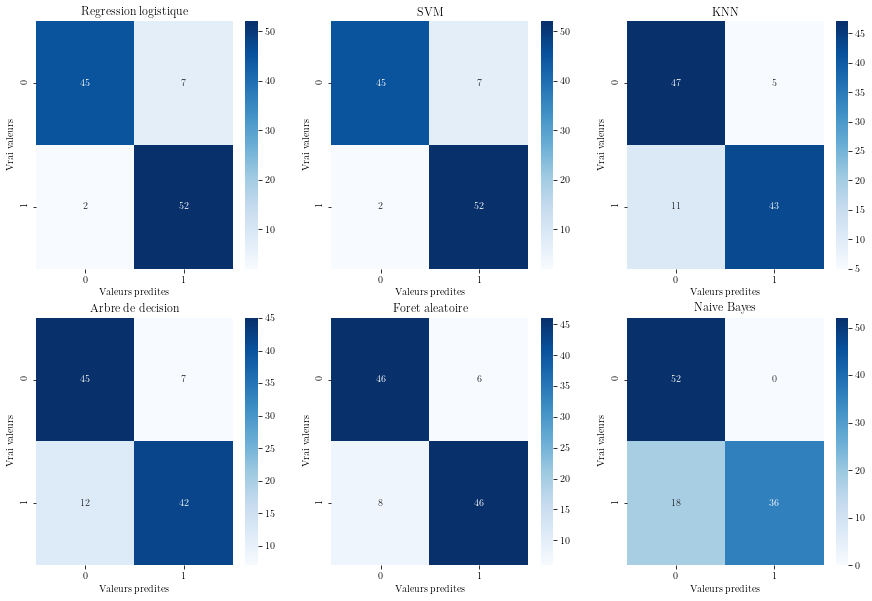

In [26]:
# Séparer les données d'entrainement et de test. 

X_train, X_test, y_train, y_test = train_test_split(feature_tente_Morse, y, test_size=0.3, random_state=1)


# Liste des différents modèles de classification utilisés

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())


# Entrainement 

model_list = ['Regression logistique', 'SVM', 'KNN', 'Arbre de decision', 'Foret aleatoire', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for classifier in model_pipeline:
    model = make_pipeline(StandardScaler(), classifier)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 8)
    auc_list.append(round(metrics.auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))


# Afficher l'accuracy et l'AUC.

result_df = pd.DataFrame({'Modèle':model_list,'Accuracy':acc_list,'AUC':auc_list})
print(result_df)


# Afficher les différentes matrices de confusions   

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    
    cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('Valeurs predites')
    cm_plot.set_ylabel('Vrai valeurs')

### Fonctions templates tentes avec filtration cubique

                  Modèle  Accuracy   AUC
0  Regression logistique  0.924528  0.93
1                    SVM  0.915094  0.92
2                    KNN  0.849057  0.85
3      Arbre de decision  0.820755  0.82
4        Foret aleatoire  0.839623  0.84
5            Naive Bayes  0.933962  0.93


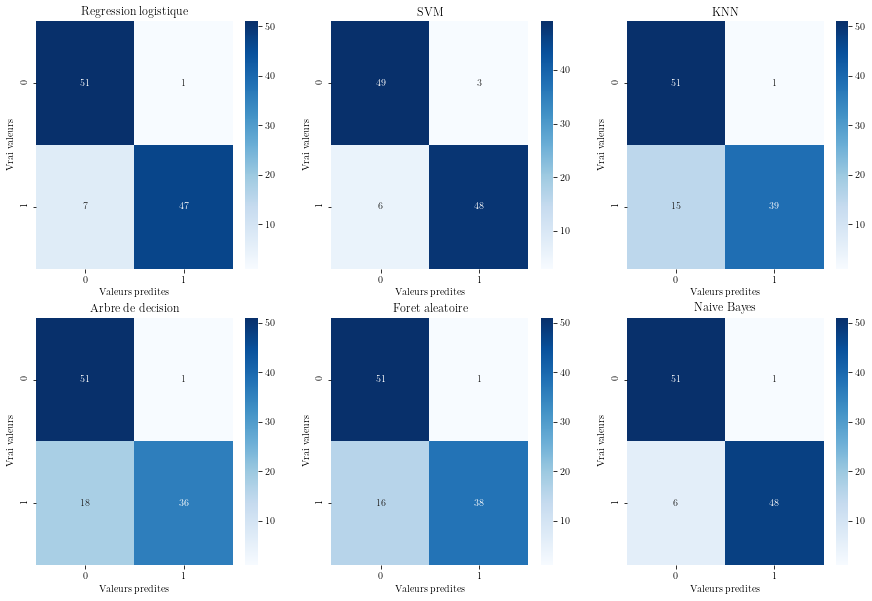

In [27]:
# Séparer les données d'entrainement et de test. 

X_train, X_test, y_train, y_test = train_test_split(feature_tente_Cubique, y, test_size=0.3, random_state=1)


# Liste des différents modèles de classification utilisés

model_pipeline = []
model_pipeline.append(LogisticRegression(solver='liblinear'))
model_pipeline.append(SVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())


# Entrainement 

model_list = ['Regression logistique', 'SVM', 'KNN', 'Arbre de decision', 'Foret aleatoire', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []

for classifier in model_pipeline:
    model = make_pipeline(StandardScaler(), classifier)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred, pos_label = 8)
    auc_list.append(round(metrics.auc(fpr,tpr),2))
    cm_list.append(confusion_matrix(y_test, y_pred))


# Afficher l'accuracy et l'AUC.

result_df = pd.DataFrame({'Modèle':model_list,'Accuracy':acc_list,'AUC':auc_list})
print(result_df)


# Afficher les différentes matrices de confusions   

fig = plt.figure(figsize = (15, 10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2, 3, i+1).set_title(model)
    
    cm_plot = sns.heatmap(cm, annot = True, cmap = 'Blues')
    cm_plot.set_xlabel('Valeurs predites')
    cm_plot.set_ylabel('Vrai valeurs')